In [9]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

from sklearn.ensemble import RandomForestClassifier

In [10]:
def f_loc(D, X):
  loc = 2*D + 2*D*X[:,4]*2*X[:,1] - 3*X[:,3]
  return(loc)

def f_scale(D,X):
  scale = np.sqrt(0.5*D + 3*D*X[:,1] + 1)
  return(scale)


def dgp(n=200, p=5):
    X = np.random.uniform(0,1,size=[n,p])
    D = (( X[:,1 ] - 0.5 + X[:,3] + np.random.normal(size=n)) > 0)*1.0
    D = ((np.random.normal(size=n)) > 0)*1.0
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X) + f_scale(D, X)*epsilon

    return Y, X, D, epsilon

In [11]:
tau_vec = np.arange(0.1,0.95,0.05)
p = 10
n_true = int(10e+6)

_, X_true, _, epsilon_true = dgp(n=n_true, p = p)
D1 = np.ones(n_true)
D0 = np.zeros(n_true)

Y1 = f_loc(D1, X_true) + f_scale(D1, X_true)*epsilon_true
Y0 = f_loc(D0, X_true) + f_scale(D0, X_true)*epsilon_true

Y1_quant = np.quantile(Y1, q=tau_vec)
Y0_quant = np.quantile(Y0, q=tau_vec)

Y1_cvar = [Y1[Y1 >= quant].mean() for quant in Y1_quant]
Y0_cvar = [Y0[Y0 >= quant].mean() for quant in Y0_quant]

print(f'Conditional Value at Risk Y(0): {Y0_cvar}')
print(f'Conditional Value at Risk Y(1): {Y1_cvar}')

Conditional Value at Risk Y(0): [-1.2439249173522835, -1.137629539548311, -1.0357000957120959, -0.9360432260671717, -0.8373088310042566, -0.7384080529128403, -0.638405102077362, -0.5363872673390003, -0.4314136009046926, -0.32235651638707674, -0.20783296409795285, -0.08603211803577823, 0.045513004942471416, 0.19062232103133323, 0.3553478164248817, 0.5506503409178033, 0.8001594489443126]
Conditional Value at Risk Y(1): [1.8965962242791619, 2.0606970144931114, 2.2188330456725343, 2.3744541563309327, 2.529912610428436, 2.687068200935013, 2.8476149111084026, 3.013280975329517, 3.1859742869582006, 3.3679986421071, 3.5622155260592954, 3.7724325593236756, 4.004166488002378, 4.265531675751145, 4.569745642982757, 4.940817181023902, 5.430415540653729]


In [12]:
n = 500
p = 5

np.random.seed(42)
Y, X, D, _ = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D)

In [13]:
ml_m = RandomForestClassifier(n_estimators=200)
ml_g = RandomForestClassifier(n_estimators=200)

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")

CVAR_0 = np.full((len(tau_vec)), np.nan)
CVAR_1 = np.full((len(tau_vec)), np.nan)

ci_CVAR_0 = np.full((len(tau_vec),2), np.nan)
ci_CVAR_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_CVAR_0 = dml.DoubleMLCVAR(obj_dml_data,
                                ml_g, ml_m,
                                quantile=tau,
                                treatment=0,
                                n_folds=5)
    dml_CVAR_1 = dml.DoubleMLCVAR(obj_dml_data,
                                ml_g, ml_m,
                                quantile=tau,
                                treatment=1,
                                n_folds=5)

    dml_CVAR_0.fit(n_jobs_cv=n_cores-1)
    dml_CVAR_1.fit(n_jobs_cv=n_cores-1)

    ci_CVAR_0[idx_tau, :] = dml_CVAR_0.confint(level=0.95).to_numpy()
    ci_CVAR_1[idx_tau, :] = dml_CVAR_1.confint(level=0.95).to_numpy()

    CVAR_0[idx_tau] = dml_CVAR_0.coef
    CVAR_1[idx_tau] = dml_CVAR_1.coef

Number of Cores: 8
Quantile: 0.1
Quantile: 0.15000000000000002
Quantile: 0.20000000000000004
Quantile: 0.25000000000000006
Quantile: 0.30000000000000004
Quantile: 0.3500000000000001
Quantile: 0.40000000000000013
Quantile: 0.45000000000000007
Quantile: 0.5000000000000001
Quantile: 0.5500000000000002
Quantile: 0.6000000000000002
Quantile: 0.6500000000000001
Quantile: 0.7000000000000002
Quantile: 0.7500000000000002
Quantile: 0.8000000000000002
Quantile: 0.8500000000000002
Quantile: 0.9000000000000002


In [14]:
data = {"Quantile": tau_vec, "CVaR Y(0)": Y0_cvar, "CVaR Y(1)": Y1_cvar,
        "DML CVaR Y(0)": CVAR_0, "DML CVaR Y(1)": CVAR_1,
        "DML CVaR Y(0) lower": ci_CVAR_0[:, 0], "DML CVaR Y(0) upper": ci_CVAR_0[:, 1],
        "DML CVaR Y(1) lower": ci_CVAR_1[:, 0], "DML CVaR Y(1) upper": ci_CVAR_1[:, 1]}
df = pd.DataFrame(data)
print(df)

    Quantile  CVaR Y(0)  CVaR Y(1)  DML CVaR Y(0)  DML CVaR Y(1)  \
0       0.10  -1.243925   1.896596      -1.330774       1.975971   
1       0.15  -1.137630   2.060697      -1.165186       2.074588   
2       0.20  -1.035700   2.218833      -1.031212       2.265002   
3       0.25  -0.936043   2.374454      -0.908922       2.443976   
4       0.30  -0.837309   2.529913      -0.803346       2.566826   
5       0.35  -0.738408   2.687068      -0.723750       2.678139   
6       0.40  -0.638405   2.847615      -0.640416       2.969180   
7       0.45  -0.536387   3.013281      -0.546596       3.075073   
8       0.50  -0.431414   3.185974      -0.341603       3.351954   
9       0.55  -0.322357   3.367999      -0.246543       3.478016   
10      0.60  -0.207833   3.562216      -0.137976       4.112539   
11      0.65  -0.086032   3.772433      -0.013827       4.084582   
12      0.70   0.045513   4.004166       0.196556       4.547276   
13      0.75   0.190622   4.265532       0.56045

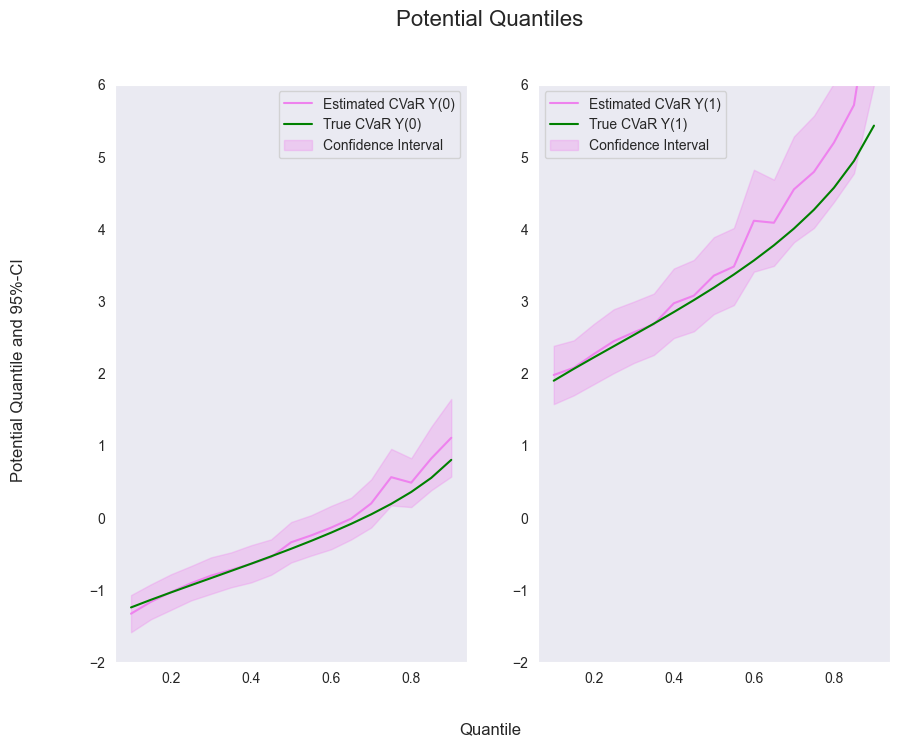

In [15]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(); ax2.grid()

ax1.plot(df['Quantile'],df['DML CVaR Y(0)'], color='violet', label='Estimated CVaR Y(0)')
ax1.plot(df['Quantile'],df['CVaR Y(0)'], color='green', label='True CVaR Y(0)')
ax1.fill_between(df['Quantile'], df['DML CVaR Y(0) lower'], df['DML CVaR Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-2, 6)

ax2.plot(df['Quantile'],df['DML CVaR Y(1)'], color='violet', label='Estimated CVaR Y(1)')
ax2.plot(df['Quantile'],df['CVaR Y(1)'], color='green', label='True CVaR Y(1)')
ax2.fill_between(df['Quantile'], df['DML CVaR Y(1) lower'], df['DML CVaR Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-2, 6)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('Potential Quantile and 95%-CI')